# Convolutional Neural Networks for Image Recognition

<font color='red'>This is the dev branch of the tutorial. Red indicates parts which need to be updated.</font>

### Credits
This tutorial was heavily borrowed from the [d2l.ia](http://d2l.ai/). Major changes made include:
* Simplification and adaptation to cpu-only implementation
* Comments and descriptions of the functions

Note the sample code in the d2l.ia [repo](https://github.com/d2l-ai/d2l-en) is subject to a modified [MIT License](https://en.wikipedia.org/wiki/MIT_License). See the source [github repo](https://github.com/bbpi2/cnn-pytorch-tutorial) for the licensing of this tutorial.

---

## 1. Introduction

In this tutorial, we will be building a Convolutional Neural Network (CNN) as a model to classify images. Pre-requisites:
* Basic knowledge of Python \& Jupyter Notebooks. If you have not used Python before, please refer to the <font color='red'>Primer</font>.
* Basic knowledge of CNNs from either the previous presentation or otherwise. For some references, please refer to this [excellent course by Stanford Unviersity](https://cs231n.github.io/convolutional-networks/).

### 1.1 PyTorch
<font color='red'>Need to add primer for why we use libraries</font>.

There are many Python libraries which facilitate Deep Learning and Neural Networks. Currently the two most popular are [TensorFlow](https://www.tensorflow.org/) (owned by Google) and [PyTorch](https://pytorch.org/) (owned by Facebook). Both are open-sourced, which means the code is available for all to see and make improvements upon. TensorFlow has a frontend application called [Keras](https://keras.io/) which makes creating a neural network in TensorFlow a little easier at the expense of some flexibility. For pedagogical reason, this tutorial will focus on using PyTorch. After gaining some familiarity with PyTorch, learning TensorFlow with Keras should be a simpler exercise.

### 1.2 Key Libraries
Here are the key libraries we will be using:

| Library | Description |
| --- | --- |
| `torch` | This is the core `PyTorch` library doing most of the heavy lifting |
| `torchvision` | This is how we will extract the data (if needed), and apply some cleaning to images |
| `random` | This library provides random number generators. This is important if we want to sample images from our dataset | 
| `matplotlib.pyplot` | This is a very popular plotting library |
| `time` | This has functions which allows us to keep track of how long the code takes to run |
| `IPython` | This libraries allows us to access some of the options of these notebooks |
| `numpy` | This is a very popular data manipulation library |

The follow code imports the libraries into our current environment.

In [1]:
import torch 
import torchvision
from torch import nn 
from torchvision import transforms
from torch.utils import data
import random
import matplotlib.pyplot as plt
import time
from IPython import display
import numpy as np

random.seed(2021) # We set a seed to ensure our samples will be the same every time we run the code.

In [10]:
# from importlib import reload
# helper = reload(helper)
# from torchvision import datasets

# <font color='red'>STOP!!!!!!!!!!!! Run the two helper function cells at the bottom before proceeding</font>

## 2. Data Science Pipeline
Before we jump into implementing the fancy neural networks, it is important for us to understand the data science process. Neural networks are but a tool that form part of an overall exercise of understanding and analysing data. The overarching goal should be to draw novel insights from data (often about the real world), and them subsequently making inferences (decisions) about them. There is no clear concensus about what the analysis process should really be like, at its crux, here are some key elements:

1. Identify your problem (what exactly are you trying to achieve?)
2. Obtain your data (what is the raw resource we have to work with?)
3. Explore your data (often, we're not the ones who have collected it, so we need to make sure to understand it)
4. Prepare/Clean/Wrangle your data (this involves many many things, from dealing with missingness, to standardising)
5. Model your data (this is where neural networks can come in)
6. Evaluate your models (how good are your predictions? Is it biased? Can we do better? How much would improvements cost?)
7. Deploy your model (this is a whole other rabbit hole that we will only touch upon).

### 2.1 Identify Your Problem
For the purpose of this tutorial, let's consider a hypothetical. Your boss comes up to you and tells you that you will be given lots and lots of black and white pictures of clothing. Your job is to identify what type of clothing each image pertains to. Of course, you can just look at the image, and make that decision. But the problem with this approach is that it is not **scalable**. It's fine for maybe 100 or 1,000 images, but what if you had 1,000,000? What if you needed to sort through all 1 million in a day? I'm sure after 10,000 you'd already be tired and your decision making won't be as sharp as the first 10k, so you lose even a bit of consistency. This is the perfect problem for machine learning because it is:
* Scalable -- once we have a *good enough* model, we can just run it over however many examples our heart desires (limited only by computational resources).
* Consistent -- in the long term, the data-driven decisions of the algorithm will be more consistent than a group of humans (or even one very tired human)

### 2.2 Obtain Your Data
Lucky for you, your boss mentioned that previously they hired some poor soul who managed to sort through 70,000 of these images already. For example, the following image is a boot:

![Boot](./images/boot.png)

You do a bit of data exploration and you find the following facts:
* There are 70,000 labelled images.
* Each image is an item of clothing.
* Each image is a 28x28 sized image (784 pixels in total).
* Each pixel is black and white, and has a value between 0 and 255 indicating the brightness of the pixel
* There are a total of 10 types of items of clothing.

| Label | Type of Clothing |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat | 
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle Boot |

In fact, the dataset we are working with is called the [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist). Below we will define a function to extract the data in a particular way. There is no need to fully understand what it's doing, only what inputs and outputs are associated with this function.

**Input:**
* `batch_size` - the number of examples (images) we run for each mini-batch (we will come back to this later)
    * If you are running this on mybinder, set `batch_size = 1024` or higher
    * If you are running this on your own machine, set `batch_size = 256` or higher
* `n_workers` - how many computer cores we want to employ for reading the data 
    * If you are running this on mybinder, set `n_workers = 0`
    * If you are running this on your own machine with CPU only, set `n_worker = 4`
    * If you are running this on your own machine with GPU also, set `n_worker = 4n`, where `n` is the number of cores in your GPU (eg. if `n=4` then `n_workers=16`)

*If you are running this on a GPU, there is a post-script on how to do this. We recommend running it on CPU first then trying GPU as a challenge.*

**Output:**
* `train_iter` - this is a train set with 60,000 units
* `test_iter` - this is a test set with 10,000 units

*We will come back to the idea of train/test split later on.*

In [4]:
def load_data_fashion_mnist(batch_size, n_workers=0):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="./data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="./data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=n_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=n_workers))

In [20]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size) # n=60000

At this point, we will have two datasets: `train_iter` and `test_iter` which total 70,000 labelled images. If you are familiar with Python, you may want to try to have a look at a single example from these datasets. This can be done with the `print()` function.

In [6]:
print(train_iter)

Hmm this is weird, why does it not show the dataset? Maybe if we try to extract a single example?

In [7]:
print(train_iter[0])

TypeError: 'DataLoader' object is not subscriptable

Error! That's strange indeed. Why is this the case? The answer is quite complicated. If you are interested, scroll down to the appendix to find out more. For now, just know that this is the way to extract a single example.

In [8]:
# First we extract a few random batches (say 3), each of which will have up to your set batch_size (eg. 1024 for mybinder)
sampled_batches = random.sample(list(train_iter), 3)
print("The number of batches we have extracted are:", len(sampled_batches))

# Second we select a single batch to look at, let's say the 3rd one
batch_no = 2
## 0 denotes the predictors
## 1 denotes the labels
predictor = sampled_batches[batch_no][0]
label = sampled_batches[batch_no][1]
print("The number of examples in the batch we selected are:" , len(predictor), " and ", len(label), ". Note these two values should be equal.")

# Third, we select a single example in the batch, let's say the 100th one
example_no = 99
single_predictor = predictor[example_no]
single_label = label[example_no]
print("The shape of the predictor", single_predictor.shape)
print("The shape of the label", single_label.shape)

The number of batches we have extracted are: 3
The number of examples in the batch we selected are: 1024  and  1024 . Note these two values should be equal.
The shape of the predictor torch.Size([1, 28, 28])
The shape of the label torch.Size([])


Let's go into the last two lines in a bit of detail. 

The predictor has the shape `[1, 28, 28]`. The first number indicates the channel. Since we are dealing with black and white, we only really need 1. For colour, this should be 3 (RGB). The 2nd and 3rd number are the width and the height of the image.

The label has the shape `[]`, which means it is just a number.

Now finally, we can print the predictor (example) and the label:

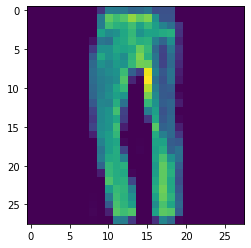

This shows an image of:  1


In [9]:
plt.imshow(single_predictor[0]) # print only the one channel of BW
plt.show()

print("This shows an image of: ", int(single_label))

### 2.3 Explore Your Data
The main thing we will be doing in this section is looking at the class distribution of the examples. That is, how spread out is each type of clothing? Is it representative? etc. We will not be looking at the code in detail, so we have written a function to do this exploration for us.

In [10]:
def data_explore(data_iter):
    class_count = Accumulator(10)
    for i, (X, y) in enumerate(data_iter):
        current_counter = torch.bincount(y)
        class_count.add(current_counter[0], current_counter[1], current_counter[2], current_counter[3], current_counter[4],
                  current_counter[5], current_counter[6], current_counter[7], current_counter[8], current_counter[9])
    for i in range(10):
        print("Class", i, "has", int(class_count.__getitem__(i)), "images")
        
    return
        
print("Train Data:")
data_explore(train_iter)
print("Test Data")
data_explore(test_iter)

Train Data:
Class 0 has 6000 images
Class 1 has 6000 images
Class 2 has 6000 images
Class 3 has 6000 images
Class 4 has 6000 images
Class 5 has 6000 images
Class 6 has 6000 images
Class 7 has 6000 images
Class 8 has 6000 images
Class 9 has 6000 images
Test Data
Class 0 has 1000 images
Class 1 has 1000 images
Class 2 has 1000 images
Class 3 has 1000 images
Class 4 has 1000 images
Class 5 has 1000 images
Class 6 has 1000 images
Class 7 has 1000 images
Class 8 has 1000 images
Class 9 has 1000 images


The class distribution is perfectly balanced as you would expect from a nice and clean dataset!

### 2.4 Prepare Your Data
This was something we have previously alluded to, but we have 70,000 labelled examples. Perfect! Do we throw them all into the training/fitting process of the model?

The answer is **NO**. Why is that though? Doesn't more data = better model?

![yesbutno](./images/yesbutno.jpg)

The reason lies in a concept known as **overfitting**. Remember, our goal is to make sure the model works well on hiterto unseen data (ie. unlabelled data). If we just throw all the data we have into the train process, then we won't have access to an independent dataset to evaluate the model. Later on, we will see how the test data can be used to assess overfitting. For now, just remember that it is vital that we have an (representative) subset of the labelled data set aside for evaluation. For the purposes of this example, 60,000 images will be used to train and 10,000 images will be used to test:
* `Train` -- this is the data we use to fit the model (n=60,000)
* `Validate` -- we will not be using this today to tune hyper-parameters
* `Test` -- this is the data we use to determine the model performance (n=10,000)

#### Aside: Validate \& Hyperparameters
**Hyperparameters** are parameters of the model that the user has to provide (as opposed to parameters the model finds such as the weights of a neural network). Examples of this might be the learning rate of the gradient descent method (denoted by `lr` later). Since these parameters have to be provided by the user, we need to decide on its value somehow. In the absence of any external information (eg. someone told us a particular learning rate is really good), we use the validate set (independent of train and test) to set these. In the example of learning rate, we may try the learning rate in increments of `0.1` between `0.1` and `0.9`. Then we choose the hyperparameter which gives us the best performance when assessed against the validate set.

*For the purpose of this tutorial, we will not do any hyperparameter tuning, so a validate set was not used.*

### 2.5 Model Your Data
Let's review what we have done so far:

|Pipeline | Our Problem |
|---| --- |
|1. Identify Your Problem | Classify images of items of clothing |
|2. Obtain Your Data | 70,000 labelled images (10 different types) of clothes |
|3. Explore Your Data | Class distribution perfectly equal across classes |
|4. Preare Your Data | Split 70,000 into 60,000 train and 10,000 test set |

Note that we didn't have to do too much cleaning because the data we have is close to *perfect* in many regards. For further details about intricacies of this process, this excellent [textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) provides all the nitty gritty detail. 

Now comes the exciting part! Building the neural network from scratch.

The architecture of the neural network we are going to build was first formulated by Yann LeCun (one of the founding fathers of deep learning) as he was working in Bell Laboratory. Here is the [original paper](https://www.researchgate.net/publication/2985446_Gradient-Based_Learning_Applied_to_Document_Recognition) if you are interested. In this instance, we will be building a slightly adapted version that the d2l.ai textbook outlines in [this chapter](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html). (The key difference is that we will be dropping the Gaussian activation function in the final layer).

![lenet](./images/lenet.svg)

**Figure 1:** The architecture of LeNet. ([source](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html))

![lenetsimple](./images/lenet-vert.svg)

**Figure 2:** Compact version of the architecture of LeNet. ([source](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html))

Okay, so that's a lot. But the building blocks are not complex. There are three main ones. Parenthesis indicates the relevant PyTorch function:
1. Convolution Layer (`Conv2d`)
2. Pooling Layer (`AvgPool2d`)
3. Dense/Linear Layer (`Linear`)

#### 2.5.1 Convolution Layers
Let's take the first transition (from 28x28 image to the 6@28x28 C1 feature map in the Figure 1) as our example. Figure 2 provides us with 3 bits of vital information:
* $5 \times 5$ means that our convolution window (aka kernel size) is going to be 5
* pad 2 means that we will 'pad' our image with two squares of 0s (since it's 28x28, this will make it a 30x30 image)
* conv(6) means that we are expecting 6 output layers (that is we pass the image through 6 filters)

An additional piece of information:
* We are starting with a black and white image, so we are expecting a single input layer

Putting this together, the code becomes: `nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size=5, padding=2)`.

What does this actually look like though? The animation from the Stanford University [course](https://cs231n.github.io/convolutional-networks/) gives an excellent intuitive picture as to what is happening.

Question: What is going to be the output dimension of our image?

<font color='red'>Examples! Maybe discuss [cross-correlation](http://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html?highlight=cross%20correlation) also</font>.

#### 2.5.2 Pooling Layers
There are two pieces of information from Figure 2:
* $2 \times 2$ AvgPool means we take $2 \times 2$ values of the image and we average them
* stride 2 means we 'skip' two steps with each window

Putting this together, the code becomes: `nn.AvgPool2d(kernel_size=2, stride=2)`.
<font color='red'>Examples!</font>.


#### 2.5.3 Linear/Dense Layer
Let's look at the FC(120) layer in Figure 2. The input is 16 layers of 5x5 images. How many pixels is that? $16 \times 5 \times 5 = 400$. We squish each pixel into a fully connected layer with 120 as the output.

Putting this together, the code becomes: `nn.Linear(in_features = 16 * 5 * 5, out_features = 120)`.

<font color='red'>Examples!</font>.


#### 2.5.4 Tying Loose Ends
Between each layer, we will use a sigmoid function `nn.Sigmoid()` as our activation function. Note we do not need to put activation functions after pooling layers, only after convolutional and linear layers. 

To convert from a 2D image representation to a 1D linear representation, we use the `nn.Flatten()` function. Try filling out the `?` below according to the architecture.

In [21]:
# Initialise LeNet Architecture
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    ?, ?,
                    ?, nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), ?,
                    ?, ?, 
                    nn.Linear(84, 10))

SyntaxError: invalid syntax (Temp/ipykernel_9956/3250750114.py, line 4)

In [22]:
# Initialise LeNet Architecture (ans)
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(), 
                    nn.Linear(84, 10))

In [23]:
# Show layers
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:    \t', X.shape)

Conv2d output shape:    	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:    	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:    	 torch.Size([1, 6, 14, 14])
Conv2d output shape:    	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:    	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:    	 torch.Size([1, 16, 5, 5])
Flatten output shape:    	 torch.Size([1, 400])
Linear output shape:    	 torch.Size([1, 120])
Sigmoid output shape:    	 torch.Size([1, 120])
Linear output shape:    	 torch.Size([1, 84])
Sigmoid output shape:    	 torch.Size([1, 84])
Linear output shape:    	 torch.Size([1, 10])


### 2.5.5 Training with a single mini-batch
Before we start with the training process, all the weights in our neural network must be initialised with a particular value. A sensible starting point is using the [Xavier Uniform](https://pytorch.org/docs/stable/nn.init.html#) distribution as outlined in [this paper](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). No further justification will be given in this tutorial, although initial weight values of neural networks can spark fascinating discussions in and of themselves.

In [24]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # We will only set the weights from linear and Conv2d layers, since pooling layers do not require this
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights) # nb: this takes in a function as an argument

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

Three key decisions need to be made by the user (hyperparamters in one sense):
* Learning Rate - How quickly should our algorithm converge? Too quick and we might *miss* the optimal model; Too slow and it will take a long time to run
* Optimiser - what algorithm do we use to find the optimal weights? For this we will use [Stochastic Gradient Descent (SGD)](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)
* Loss Function - how do we measure the 'correctness' of predictions? For this we will use the [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

*No further justification will be provided for these, but one should note this is not the only configuration, nor might this be the best configuration. For example the ADAM optimiser is often preferred over SGD.*

In [25]:
lr = 0.9 # Learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=lr) # Using SGD algorithm ot optimise
loss = nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

This next step is just to set the neural network into training mode, and not to actually train it itself.

In [26]:
net.train() # This doesn't actually train, but sets the network on training mode

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

This next bit is where the training happens

In [27]:
X, y = next(iter(train_iter)) # Pick a single minibatch at random to do the training
optimizer.zero_grad() # before running the forward/backward pass we need to reset the gradient (otherwise it accumulates)
y_hat = net(X) # Forward pass on the data to make prediction
l = loss(y_hat, y) # calculate the loss 
l.backward() # back propagate the loss to update the weights
optimizer.step() # step forward in optimisation

And that's it! Pat yourselves on the back, because you've trained your very first CNN for image recognition.

### 2.6 Evaluate Your Model
Okay, that's all well and good, but how well does it actually perform? Let's extract some of the accuracies. 

#### 2.6.1 Train Accuracy

In [28]:
metric_1 = l * X.shape[0]
metric_2 = accuracy(y_hat, y)
metric_3 = X.shape[0] 


print("1. The mini-batch loss is: \t\t\t\t", metric_1)
print("2. The number of correct training predictions is: \t", metric_2)
print("3. The number of total training predictions is: \t", metric_3)

print("This means we get a training accuracy of ", metric_2/metric_3)
print("The average loss for each example is ", float(metric_1/metric_3))

1. The mini-batch loss is: 				 tensor(640.7407, grad_fn=<MulBackward0>)
2. The number of correct training predictions is: 	 23.0
3. The number of total training predictions is: 	 256
This means we get a training accuracy of  0.08984375
The average loss for each example is  2.5028934478759766


#### 2.6.2 Test Accuracy

In [29]:
test_accuracy = evaluate_accuracy(net, test_iter)
print("The testing accuracy is: ", test_accuracy)

The testing accuracy is:  0.1


The train and test accuracy both hover around 10%. That means the model gets the right label about 1 in 10 times. This is no better than randomly picking labels for each image! However, we have only trained over a single mini batch of data. Of course the performance is going to be low. In reality we need to run it over the entire data at least once. Each time we run over the train data once is called an epoch. In the next section we will talk about scaling this up for more training examples.

## 3. Scaling Up the Training

In [30]:
net.apply(init_weights) # let's reset the NN weights

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
timer = Timer() 
num_epochs = 500

# Keep track of accuracy for each epoch
train_accuracy = np.array([])
test_accuracy = np.array([])
epochs = np.arange(num_epochs) + 1

for epoch in range(num_epochs):
    metric = Accumulator(3) # define a 3d accumulator
    net.train() # set to train
    for i, (X, y) in enumerate(train_iter): # Loop thru each mini-batch
        timer.start()
        optimizer.zero_grad() # before running the forward/backward pass we need to reset the gradient (otherwise it accumulates)
        y_hat = net(X) # Forward pass on the data to make prediction
        l = loss(y_hat, y) # calculate the loss 
        l.backward() # back propagate the loss
        optimizer.step() # step forward in optimisation
        with torch.no_grad():
            metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0]) # mini-batch loss,  # matches, # total examples
        timer.stop()
        train_l = metric[0] / metric[2] # loss per unit 
        train_acc = metric[1] / metric[2] # training accuracy
    test_acc = evaluate_accuracy(net, test_iter)
    
    train_accuracy = np.append(train_accuracy, train_acc)
    test_accuracy = np.append(test_accuracy, test_acc)

print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
      f'test acc {test_acc:.3f}')
print(f'{timer.sum():.1f} sec taken ')

loss 0.001, train acc 1.000, test acc 0.904
2606.5 sec taken 


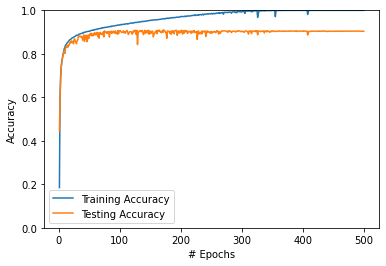

In [33]:
plt.plot(epochs, train_accuracy, label = "Training Accuracy")
plt.plot(epochs, test_accuracy, label = "Testing Accuracy")
plt.ylim(0, 1)
plt.xlabel("# Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

---

# HELPER FUNCTIONS
Please run the TWO cells below directly after the preamble

In [2]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def print(self):
        print(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    """Compute the number of correct predictions.
    Defined in :numref:`sec_utils`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # ensure there's more than one example 
        y_hat = argmax(y_hat, axis=1) # Choose the column corresponding to theb highest y_hat
    cmp = astype(y_hat, y.dtype) == y # see if it matches
    return float(reduce_sum(astype(cmp, y.dtype))) #check how many matches there are

astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)

def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module): # Check if net is a nn.Module (type)
        net.eval()  # Set the model to evaluation mode
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [3]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_normal_distribution_and_squared_loss`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.
    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib.
    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.
    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

---

You may notice that if you try to print the `train_iter` or `test_iter`, you'll get some weird object rather than the data itself. The reason for this is that we have opted to load the data via **generator functions** rather than directly. This means that unless the data is required at this moment, we will not need to store it, thus saving memory space. This method is often used in deep learning as the datasets we work with are often huge and cannot be stored properly in memory.

# Convolutional Neural Networks in `PyTorch`

In this tutorial, we will be building a Convolutional Neural Network (CNN) from the ground up using the `Python` library `PyTorch`. There are two main competing libraries when it comes to implementing neural networks in `Python`:
 * `tensorflow`: written with productionisation in mind
 * `pytorch`: written with experimentation and development of novel methods in mind

For basic implementations of neural networks, most people use the package `keras` as a front-end to `tensorflow`. This allows the developer to build simple architectures with easy. `pytorch` does not come with a similar front-end, but its complexity also allows a huge level of flexibility

## Convolutional Neural Networks
CNNs are neural network architectures which facilitates the processing of image data using a technique called a convolution (or a window function). The very first CNN was pioneered by Yann LeCun -- often known as one of the founding fathers of neural networks -- in 1998 [here](https://www.researchgate.net/publication/2985446_Gradient-Based_Learning_Applied_to_Document_Recognition).

CNNs have to contend with the particularly challenging structure of image data. For simplicity sake, we will limite ourselves to a 28x28 black and white image. With 28x28 pixels, we have a total of 784 pixels with some sense of local 2D structure. Each pixel has a single channel which represents the lightness (or darkness) of that particular point.

**NOTE** This tutorial is heavily dependent on the classes defined in [d2l](https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py), which have been forked for convenience

The best way to understand the data is by looking at a few examples. Here's one:


Which label do you think this image belongs to? 

The purpose of our model is for the computer to automatically take in each of these images, and spit out the (hopefully correct!) label.

Image -> Model -> Label

The process of refining the model to produce accurate results is called **training/fitting**, which requires labelled data to do. You are effectively learning the pattern between the input image and the output label.

## 3. Train-Validate-Test Split

#### ***[Advanced]: Data Types
*Ignore this section if you have never used Python before.*

##### \*.1 Typical Data Ingress
If you have done any analysis in Python before you may be familiar with a typical data ingression. More often than not you will read in a `.csv` file and then cast it into a `numpy` or `pandas` object. For the R users, this is effectively a dataframe, and for the SAS users, this is simply a dataset item (like `.sas7bdat` objects). Either way, `numpy` and `pandas` objects are relatively straight-forward, you can access any part of it at anytime because the data is stored in your memory (RAM). This is normally accessible by the `print()` statement:

In [25]:
print(train_iter)
print(len(train_iter))

59


This is weird. What exactly is this `DataLoader` object?! How do we get the actual data itself?

The length of the iterator makes sense.

PyTorch comes with two different ways of reading data. The `DataSet` method reads very much like a `numpy` or `pandas` object. You can access individual examples by indexing the object. Let's try that below:

In [24]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=ToTensor()
)

print(training_data[0]) # Get the first element of the training set.

# Free up some memory
import gc
del training_data
gc.collect()

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000

0

The reason for this is simple. The `DataSet` object reads all the necessary data into memory directly. However the `DataLoader` object creates a generator function. That is to say it creates an iterable. The `DataLoader` method will only read the data when necessary. This might seem like a lot of work for these smaller datasets. However, if you try to do this for huge datasets which might take up 10-20gb of memory, the `DataSet` method becomes unwealdy. We can still access individual examples by sampling the iterator.

If we try a similar thing for the `DataLoader` object, we don't get the same thing.

## 4. Data Formats
`torch.utils.data.DataLoader` format
Typically, when you work with datasets, you download it into your directory and you work directly with it. This is fine for smaller datasets, but when you work with massive datasets this can be unworkable. You may not have enough RAM to store the dataset in memory, and often times, you don't *need* to use all the data at the same time. `torch` comes with a useful class called `DataLoader`. Rather than directly download your dataset, it allows you to define an iterable. With an iterable, you only access the data when needed using special functions, ensuring both parallisability and efficiency.

First we must determine a batch-size:
* Small batch sizes ensures frequent updating of the model (leading to fewer epochs required), but can be more computationally expensive
* Large batch sizes are easier to run but can require more epochs to converge

You may get the following error:

```
C:\Users\Brian\anaconda3\envs\ML-sandbox\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  
```

This can be ignored

In [6]:
print(train_iter)

Okay, so it appears that I can't print out the value of `train_iter` since it's a dataloader object. This makes sense since this is a generator object. We need to think of more creative ways of outputting this. First let's think about how many units we expect in `train_iter`. There are 60,000 training examples, and we batch them up into batch sizes of 256 -- this means there should be 235 batches (rounded up as the final batch will have less than 256 units, but that's fine).

In [7]:
print(len(train_iter))

59


This is as expected! In order to print out an individual example or batch, we need to randomly sample from the generator. For example's sake let's get 3 batches.

In [8]:
sampled_batches = random.sample(list(train_iter), 3)
len(sampled_batches) # shows how many batches there are

3

In [9]:
len(sampled_batches[0])

2

In [10]:
# For argument's sake let's choose the 3rd batch
batch_no = 2

# The object is a list of lists -- each batch with two entries
# 0 denotes the predictors
# 1 denotes the labels
predictor = sampled_batches[batch_no][0]
label = sampled_batches[batch_no][1]

print("The number of exampels in the batch of the predictors are: ", len(predictor))
print("The number of exampels in the batch of the labels are: ", len(label))
print("They should be equal!")

The number of exampels in the batch of the predictors are:  1024
The number of exampels in the batch of the labels are:  1024
They should be equal!


The shape of the predictor torch.Size([1, 28, 28])
The shape of the predictor torch.Size([])


You should get the following:
* Predictor: `[1,28,28]` -- this means it's a tensor with a single channel and 28x28 (if it was RGB colour it would be `[3,28,28]`)
* Label: `[]` -- this means it's a scalar

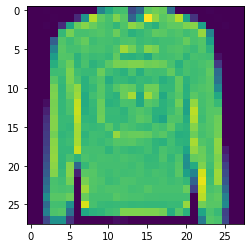

This shows an image of:  2


### A note on `grad`
Each tensor will have an option of grad or nograd. By default it is `false`. When evaluating an NN, this is the option we need, since we don't want it to track the history (required for calculating gradients). However, when training, we need to keep this on so that we can do autodiff. 

In [15]:
single_predictor.requires_grad

False